In [1]:
# If running notebook on brainlife, use ! due to version issues
# !pip install llvmlite --ignore-installed # added due to issue with (un)installing correct version
# !pip install git+https://github.com/JulioAPeraza/gradec.git

In [1]:
import itertools
import os.path as op
import os
import numpy as np
import pandas as pd

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib

### Determine tract names given a data folder with cortical surface termination maps

In [2]:
# Path to cortical surface termination maps
data_dir = op.join(".", "data")
endpt_dir = op.join(
    data_dir, 
    "white-matter-atlas_thresholds", 
    f"cortexmap_binarize_smooth-surf-1_threshold-0_dilate-0", # MAY NEED TO MODIFY thresh and dilate
    "cortexmap", 
    "func",
)

# extract all .gii file names
file_names = []
for f in os.listdir(endpt_dir):
    if f.endswith(".gii"):
        file_names.append(f)

bi_tract_names = [] # tracts with left and right tract (lh-LPI, lh-RAS, rh-LPI, rh-RAS)
mono_tract_names = [] # tracts with no left and right tract (lh-LPI, rh-RAS)

# for use inside for loop
LENGTH_HEM = len('rh.')
LENGTH_LEFT = len('left')
LENGTH_RIGHT = len('right')

# extract tract name from file name
for i in file_names:
    exclude = "rh.left" in i or "lh.right" in i # exclude if file name "rh.left..." or "lh.right..."

    if not(exclude):
        split_by_tract = i.split("_")[0][LENGTH_HEM:]
        if 'left' in split_by_tract:
            bi_tract_names.append(split_by_tract[LENGTH_LEFT:])
        elif 'right' in split_by_tract:
            bi_tract_names.append(split_by_tract[LENGTH_RIGHT:])
        else:
            mono_tract_names.append(split_by_tract)

mono_tract_names = sorted(list(set(mono_tract_names))) # sorted to keep order consistent for future indexing
bi_tract_names = sorted(list(set(bi_tract_names))) # sorted to keep order consistent for future indexing

# create single array with tract names and whether the tracts are mono or bi
all_tract_names = mono_tract_names + bi_tract_names
isMono = np.concatenate((np.ones(len(mono_tract_names), dtype=int),
                         np.zeros(len(bi_tract_names), dtype=int)))
MONO_OR_BI_DICT = dict(zip(all_tract_names, isMono)) # binary, 1 = mono tract, 0 = bi tract

# note: mono_tracts includes 5 tracts + bi_tracts include 28 --> 5 + 28*2 = 61 major white matter tracts or ROIs??

### Define space, density and paths to data

In [3]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

# data_dir = op.join(".", "data") # duplicate from code above
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")

# List of possible combinations of tracts, end points and smoothing
tracts = all_tract_names
endpts = ["RAS", "LPI"]
#tracts = ["Arc", "SLF1And2", "CST"]
#smths = ["", ".smooth_1"]
#thresholds = ["0", "0.15", "0.25"]

# Dictionaries for the title of the figures
TRACTS_DICT = dict(zip(all_tract_names, all_tract_names)) # need to eventually change
'''TRACTS_DICT = {
    "Arc": "Arcuate",
    "CST": "Corticospinal",
    "SLF1And2": "SLF 1 & 2",
    "forcepsMajor": "Forceps Major",
}
SMTHS_DICT = {
    "": "Unsmoothed",
    ".smooth_1": "Smoothed",
} '''
ENDPOINTS_DICT = { 
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}

### Train and LDA-based decoder on NeuroQuery detabase

In [9]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for analysis or visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Define functions to run decoder

In [5]:
def load_combined_maps(endpt_dir, tract, isMono):
    """
    This function loads maps when running analysis for combined endpoint ROIs (RAS+LPI)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): probability map for left hemisphere
    map_arr_rh (1D array): probability map for right hemisphere
    """
    if isMono:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
    else: # if bi tracts
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        
    return map_arr_lh, map_arr_rh

In [4]:
def load_mono_maps(endpt_dir, tract, method=""):
    """
    This function loads maps when running analysis for mono tracts, separated.
    Can be separated by hemisphere (lh vs. rh) or endpoint ROI (LPI vs. RAS). Functionally, these two are the same.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): probability map for left hemisphere
    map_arr_rh (1D array): probability map for right hemisphere
    """
    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match method:
        case "lh": # separated by lh or LPI
            map_arr_lh = nib.load(map_lpi_lh).agg_data()
            map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
        case "rh": # separated by rh or RAS
            map_arr_rh = nib.load(map_ras_rh).agg_data()
            map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
        case _: # default
            print("Error: No separation method provided.")
    
    return map_arr_lh, map_arr_rh

In [5]:
def load_bi_maps(endpt_dir, tract, splitby="", endpt="", hemisphere=""):
    """
    This function loads maps when running analysis for bi tracts, separated.
    Can be separated by hemisphere (lh vs. rh), endpoint ROI (LPI vs. RAS), or both.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    splitby (str): method of splitting. Can split by "roi", "hem", or "both"
    endpt (str): optional- endpoint ROI. "RAS" or "LPI"
    hemisphere (str): optional- hemisphere. "lh" or "rh"

    Returns
    map_arr_lh (1D array): probability map for left hemisphere
    map_arr_rh (1D array): probability map for right hemisphere
    """
    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match splitby:
        case "roi": # separated by endpoint ROI
            if endpt == "LPI": 
                map_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_arr_rh = nib.load(map_lpi_rh).agg_data()
            elif endpt == "RAS":
                map_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_rh = nib.load(map_ras_rh).agg_data()
            else:
                print("Error: Can't separate by endpoint ROI. Wrong ROI provided.")
        case "hem": # separated by hemisphere
            if hemisphere == "lh":
                map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == "rh":
                map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
                map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
                map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere 
            else:
                print("Error: Can't separate by hemisphere. Wrong hemisphere provided.")
        case "both": # separated by enpoint ROI and hemisphere
            if hemisphere == "lh":
                map_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_lh = nib.load(map_lh).agg_data()
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == "rh":
                map_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_rh = nib.load(map_rh).agg_data()
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere
            else:
                print("Error: Can't separate by endpoint ROI and hemisphere. Incorrect ROI or hemisphere provided.")
        case _: # default
            print("Error: Incorrect separation method provided.")
 
    return map_arr_lh, map_arr_rh

In [14]:
hem = "lh"
endpt = "LPI"
hem+endpt == "lhLPI"

True

### Clustering: Run decoder on each endpoint separately

In [23]:
'''IF only wanting to test a few tracts
tracts = all
endpts = ["LPI", "RAS"]
'''
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 200 topics*ROIs data table in long form. 61 ROIs or 33 ROIs.

# constants for separation method of bi tracts used inside for loop
SPLIT_ROI = "roi"
SPLIT_HEM = "hem"
SPLIT_BOTH = "both"

hemispheres_to_analyze = ["lh", "rh"] # modify this to just look at lh vs. rh or keep both 
endpts_to_analyze = ["LPI", "RAS"] # modify this to just look at ras vs. lpi or keep both

# to keep track of lh-LPI, rh-RAS for mono tracks to not have duplicate iterations
completed_dict = {"lhLPI": False, "rhRAS": False, "lhRAS": True, "rhLPI": True} # true = do not run 
prevTract = ""

for index, (tract, endpt, hem) in enumerate(itertools.product(tracts, endpts_to_analyze, hemispheres_to_analyze)):
    # Read map
    if MONO_OR_BI_DICT.get(tract): # if mono tract
        if prevTract != tract: # if new track iteration, reset values
            completed_dict["lhLPI"] = False
            completed_dict["rhRAS"] = False
        if completed_dict[hem+endpt]: # check if need to run iteration
            continue
        else:
            map_arr_lh, map_arr_rh = load_mono_maps(endpt_dir, tract, hem)
            completed_dict[hem+endpt] = True
        prevTract = tract
    else: # if bi tract
        print(tract, endpt, hem)
        map_arr_lh, map_arr_rh = load_bi_maps(endpt_dir, tract, SPLIT_BOTH, endpt, hem) # CHANGE SPLIT METHOD HERE

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # transform and concat df 
    temp_corrs_df.columns = ["r"]
    sorted_df = temp_corrs_df.sort_values(by='r', ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{hem}_{tract}_{endpt}", 
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_962006/3256806653.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

AnterioFrontoCerebellar LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

AnterioFrontoCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

AnterioFrontoCerebellar RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

AnterioFrontoCerebellar RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

Arc LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

Arc LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

Arc RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

Arc RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

Aslant LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

Aslant LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

Aslant RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

Aslant RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

CST LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

CST LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

CST RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

CST RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

ContraAnterioFrontoCerebellar LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ContraAnterioFrontoCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ContraAnterioFrontoCerebellar RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

ContraAnterioFrontoCerebellar RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

ContraMotorCerebellar LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ContraMotorCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ContraMotorCerebellar RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

ContraMotorCerebellar RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

IFOF LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

IFOF LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

IFOF RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

IFOF RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

ILF LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

ILF LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

ILF RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

ILF RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFang LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFang LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFang RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFang RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFspl LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFspl LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFspl RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

MDLFspl RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

MotorCerebellar LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

MotorCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

MotorCerebellar RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

MotorCerebellar RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

OccipitoCerebellar LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

OccipitoCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

OccipitoCerebellar RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

OccipitoCerebellar RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

ParietoCerebellar LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ParietoCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ParietoCerebellar RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

ParietoCerebellar RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF1And2 LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF1And2 LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF1And2 RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF1And2 RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF3 LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF3 LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF3 RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

SLF3 RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

TPC LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

TPC LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

TPC RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

TPC RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

ThalamicoCerebellar LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ThalamicoCerebellar LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ThalamicoCerebellar RAS lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

ThalamicoCerebellar RAS rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

Uncinate LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

Uncinate LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

Uncinate RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

Uncinate RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

VOF LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

VOF LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

VOF RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

VOF RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

baum LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

baum LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

baum RAS lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

baum RAS rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

cingulum LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

cingulum LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

cingulum RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

cingulum RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

frontoThalamic LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

frontoThalamic LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

frontoThalamic RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

frontoThalamic RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

meyer LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

meyer LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

meyer RAS lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

meyer RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

motorThalamic LPI lh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

motorThalamic LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

motorThalamic RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

motorThalamic RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

pArc LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

pArc LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

pArc RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

pArc RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

parietoThalamic LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

parietoThalamic LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

parietoThalamic RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

parietoThalamic RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

spinoThalamic LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

spinoThalamic LPI rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

spinoThalamic RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

spinoThalamic RAS rh


/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

temporoThalamic LPI lh


  0%|          | 0/1 [00:00<?, ?it/s]

temporoThalamic LPI rh


  0%|          | 0/1 [00:00<?, ?it/s]

temporoThalamic RAS lh


  0%|          | 0/1 [00:00<?, ?it/s]

temporoThalamic RAS rh


  0%|          | 0/1 [00:00<?, ?it/s]

### Clustering: Run decoder on each endpoint ROI combined

In [6]:
'''IF only wanting to test a few tracts
tracts = all
endpts = ["LPI", "RAS"]
'''
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 200 topics*ROIs data table in long form. can be 61 or 33 ROIs

for tract in tracts:
    # Read map
    map_arr_lh, map_arr_rh = load_combined_maps(endpt_dir, tract, MONO_OR_BI_DICT.get(tract))

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # transform and concat df 
    temp_corrs_df.columns = ["r"]
    sorted_df = temp_corrs_df.sort_values(by='r', ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}_LPI+RAS", 
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_938234/2637912993.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/sohmee/.local/share/virtualenvs/white_matter_tract-main-P1zb5N1J/lib/python3.10/site-packages/nimare/stats.py:108: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Clustering: Hierarchical cluster analysis

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

/tmp/ipykernel_938234/50985014.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hca = linkage((dissimilarity), 'centroid')


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [32.5, 32.5, 60.0, 60.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [46.25, 46.25, 82.5, 82.5],
  [10.0, 10.0, 64.375, 64.375],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [150.0, 150.0, 170.0, 170.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [160.0, 160.0, 192.5, 192.5],
  [130.0, 130.0, 176.25, 176.25],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [260.0, 260.0, 280.0, 280.0],
  [295.0, 295.0, 305.0, 305.0],
  [325.0, 325.0, 335.0, 335.0],
  [345.0, 345.0, 355.0, 355.0],
  [330.0, 330.0, 350.0, 350.0],
  [315.0, 315.0, 340.0, 340.0],
  [300.0, 300.0, 327.5, 327.5],
  [270.0, 270.0, 313.75, 313.75],
  [240.0, 240.0, 291.875, 291.875],
  [225.0, 225.0, 265.9375, 265.9375],
  [215.0, 215.0,

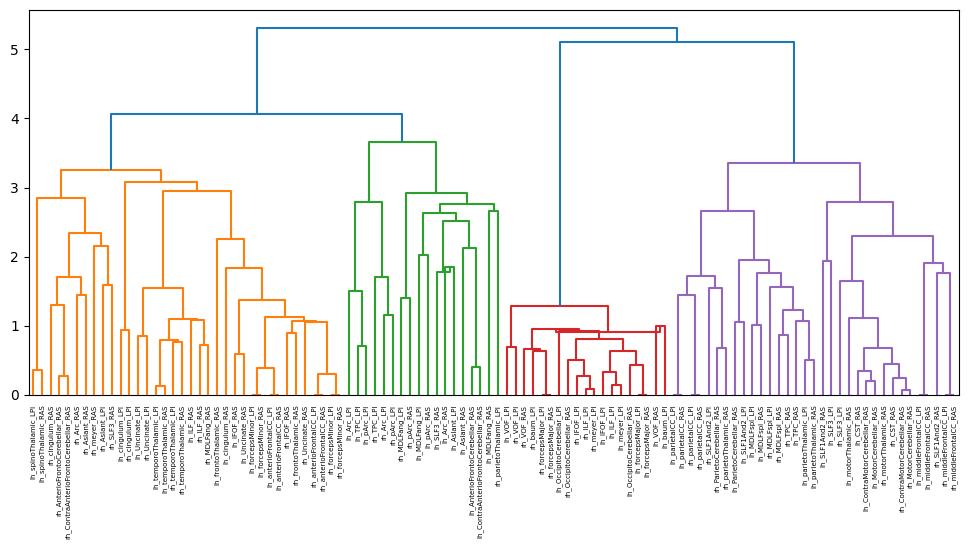

In [21]:
# transform and clean df
pivot_df = map_corr_df.pivot_table(index = 'topic', columns='ROI', values='r') # pivot from long to wide
pivot_df_cleaned = pivot_df.dropna(axis = 1) # remove col with NaN
# note to self: pivot_df.to_csv('output.csv', index=True)

# compute correlation matrix and HCA
corr_mtrix = pivot_df_cleaned.corr()
dissimilarity = 1 - corr_mtrix
hca = linkage((dissimilarity), 'centroid')

# plot dendrogram
plt.figure(figsize=(12,5))
dendrogram(hca, labels=corr_mtrix.columns, 
           orientation='top', 
           leaf_rotation=90)

### Visualization: Run decoder on each regions separate

In [55]:
sep_figures_dir = op.join(figures_dir, "separated")
os.makedirs(sep_figures_dir, exist_ok=True)

separated_results = {}
for fig_i, (threshold, tract, region, smth) in enumerate(itertools.product(thresholds, tracts, regions, smths)):
    # Path to the maps
    regions_dir = op.join(
        data_dir, 
        "white-matter-atlas_thresholds", 
        f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
        "cortexmap", 
        "func",
    )
    
    # Read maps
    map_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_{region}_FiberEndpoint{smth}.func.gii")
    map_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_{region}_FiberEndpoint{smth}.func.gii")
    map_arr_lh = nib.load(map_lh).agg_data()
    map_arr_rh = nib.load(map_rh).agg_data()

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([map_arr], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )
    filtered_df.columns = ["r"]
    separated_results[f"{tract}_{region}{smth}_thr-{threshold}"] = filtered_df.sort_values(by="r", ascending=False)

    # Visualize maps to decode
    plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} {REGIONS_DICT[region]}\n{SMTHS_DICT[smth]}. Threshold: {threshold}",
        data_dir=data_dir,
        out_fig=op.join(sep_figures_dir, f"{fig_i}-01_{tract}_{region}{smth}_thr-{threshold}_surf.png"),
    )

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    if not np.any(np.isnan(corrs)) and corrs.size > 0: # Skip one of the regions of CST
        # Radar plot
        plot_radar(
            corrs, 
            filtered_features, 
            MODEL,
            out_fig=op.join(sep_figures_dir, f"{fig_i}-02_{tract}_{region}{smth}_thr-{threshold}_radar.png"),
        )
        
        # Word cloud plot
        plot_cloud(
            corrs, 
            filtered_features,
            MODEL,
            frequencies=filtered_frequencies,
            out_fig=op.join(sep_figures_dir, f"{fig_i}-03_{tract}_{region}{smth}_thr-{threshold}_wordcloud.png"),
        )

  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/numpy/lib/npyio.py:1393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)
  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/numpy/lib/npyio.py:1393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encounte

### Run decoder on combined regions for each tract

In [20]:
com_figures_dir = op.join(figures_dir, "combined")
os.makedirs(com_figures_dir, exist_ok=True)

combined_results = {}
for fig_i, (threshold, tract, smth) in enumerate(itertools.product(thresholds, tracts, smths)):
    # Path to the maps
    regions_dir = op.join(
        data_dir, 
        "white-matter-atlas_thresholds", 
        f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
        "cortexmap", 
        "func",
    )
    
    # Read maps
    map_lpi_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_lpi_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_ras_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    map_ras_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    
    map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
    map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
    map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
    map_ras_arr_rh = nib.load(map_ras_rh).agg_data()

    # Combined regions for each tract
    map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
    map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
    
    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([map_arr], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    filtered_df.columns = ["r"]
    combined_results[f"{tract}{smth}_thr-{threshold}"] = filtered_df.sort_values(by="r", ascending=False)

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} LPI+RAS\n{SMTHS_DICT[smth]}. Threshold: {threshold}",
        data_dir=data_dir,
        out_fig=op.join(com_figures_dir, f"{fig_i}-01_{tract}_LPI+RAS{smth}_thr-{threshold}_surf.png"),
    )

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    if not np.any(np.isnan(corrs)) and corrs.size > 0: # Skip one of the regions of CST
        # Radar plot
        plot_radar(
            corrs, 
            filtered_features, 
            MODEL,
            out_fig=op.join(com_figures_dir, f"{fig_i}-02_{tract}_LPI+RAS{smth}_thr-{threshold}_radar.png"),
        )

        # Word cloud plot
        plot_cloud(
            corrs, 
            filtered_features,
            MODEL,
            frequencies=filtered_frequencies,
            out_fig=op.join(com_figures_dir, f"{fig_i}-03_{tract}_LPI+RAS{smth}_thr-{threshold}_wordcloud.png"),
        )

  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])
  0%|          | 0/1 [00:00<?, ?it/s]


115119

### Visualizaiton: Make figures - Julio's version

In [24]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

In [25]:
comb_width, comb_hight = 25, 13
sep_width, sep_hight = 25, 25

n_comb_rows, n_comb_cols = 3, 6
n_sep_rows, n_sep_cols = 6, 6

In [26]:
fig_i = 0
for thr_i, threshold in enumerate(thresholds):
    fig = plt.figure(figsize=(sep_width, sep_hight))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    gs = GridSpec(nrows=n_sep_rows, ncols=n_sep_cols, figure=fig)

    for trc_i, tract in enumerate(tracts):
        for reg_i, region in enumerate(regions):
            for smth_i, smth in enumerate(smths):
                surf_plt = op.join(sep_figures_dir, f"{fig_i}-01_{tract}_{region}{smth}_thr-{threshold}_surf.png")
                radar_plt = op.join(sep_figures_dir, f"{fig_i}-02_{tract}_{region}{smth}_thr-{threshold}_radar.png")
                wordcloud_plt = op.join(sep_figures_dir, f"{fig_i}-03_{tract}_{region}{smth}_thr-{threshold}_wordcloud.png")

                for img_i, img_file in enumerate([surf_plt, radar_plt, wordcloud_plt]):
                    ax = fig.add_subplot(gs[trc_i*2 + reg_i, smth_i*3 + img_i], aspect="equal")
                    if op.exists(img_file):
                        img = mpimg.imread(img_file)    
                        ax.imshow(img)

                    ax.set_axis_off()

                fig_i += 1

        out_file = op.join(figures_dir, f"results-separated_thr-{float(threshold):.2f}.png")
        fig.savefig(out_file, bbox_inches="tight", dpi=300)
        plt.close()

IndexError: index 6 is out of bounds for axis 0 with size 6

In [10]:
fig_i = 0
for thr_i, threshold in enumerate(thresholds):
    fig = plt.figure(figsize=(comb_width, comb_hight))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    gs = GridSpec(nrows=n_comb_rows, ncols=n_comb_cols, figure=fig)

    for trc_i, tract in enumerate(tracts):
        for smth_i, smth in enumerate(smths):

            surf_plt = op.join(com_figures_dir, f"{fig_i}-01_{tract}_LPI+RAS{smth}_thr-{threshold}_surf.png")
            radar_plt = op.join(com_figures_dir, f"{fig_i}-02_{tract}_LPI+RAS{smth}_thr-{threshold}_radar.png")
            wordcloud_plt = op.join(com_figures_dir, f"{fig_i}-03_{tract}_LPI+RAS{smth}_thr-{threshold}_wordcloud.png")
            
            for img_i, img_file in enumerate([surf_plt, radar_plt, wordcloud_plt]):
                ax = fig.add_subplot(gs[trc_i, smth_i*3 + img_i], aspect="equal")
                if op.exists(img_file):
                    img = mpimg.imread(img_file)    
                    ax.imshow(img)
                
                ax.set_axis_off()

            fig_i += 1

    out_file = op.join(figures_dir, f"results-combined_thr-{float(threshold):.2f}.png")
    fig.savefig(out_file, bbox_inches="tight", dpi=300)
    plt.close()